In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf

C:\Users\btenn\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\btenn\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\btenn\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\btenn\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

## Experiment Objective

The dataset I chose contains 10000 images of cats and 10000 images of dogs. I will use the images to train a convolutional neural network that I will use to classify new, unseen images of cats and dogs. I found the data on kaggle and downloaded the directories containing the images. Kaggle is open source and since they are only cats and dogs there are no ethical biases I have to worry about.

## Collection and Preprocessing

The dataset's directory structure has seperate directories of training and test sets. The training and test directories are further divided into a cat directory and a dog directory. First I collect all jpg file paths then combine the training cats with training dogs and repeat for the test set.

In [2]:
import pathlib

dog_trn_path = pathlib.Path('dataset/training_set/dogs')
cat_trn_path = pathlib.Path('dataset/training_set/cats')
dog_test_path = pathlib.Path('dataset/test_set/dogs')
cat_test_path = pathlib.Path('dataset/test_set/cats')

dog_trn_list = sorted([str(path) for path in dog_trn_path.glob('*.jpg')])
cat_trn_list = sorted([str(path) for path in cat_trn_path.glob('*.jpg')])

train_file_list = dog_trn_list+cat_trn_list

dog_test_list = sorted([str(path) for path in dog_test_path.glob('*.jpg')])
cat_test_list = sorted([str(path) for path in cat_test_path.glob('*.jpg')])

test_file_list = dog_test_list+cat_test_list

I created lists of variables based on if the image has 'dog' or 'cat' in the filename.

In [4]:
import os
train_labels = [1 if 'dog' in os.path.basename(file) else 0 for file in train_file_list]
test_labels = [1 if 'dog' in os.path.basename(file) else 0 for file in test_file_list]

Function to read in the images, decode them a resize them. My computer didn't have enough memory for 64by64 pixel images so I had to compress them to 32x32.

In [5]:
def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image,channels=3)
    image = tf.image.resize(image,[img_height,img_width])
    image /= 255.0
    return image, label

img_height, img_width = 32,32
BATCH_SIZE = 32
num_epoch = 20

In [6]:
trn = tf.data.Dataset.from_tensor_slices((train_file_list,train_labels)).map(process_image).shuffle(8000).repeat().batch(64)
tst = tf.data.Dataset.from_tensor_slices((test_file_list,test_labels)).map(process_image).shuffle(2000).batch(64)

## Model Creation

I added two convolutional layers both with same padding to maintain the spatial dimensions of my images followed by max pooling to reduce the dimensions of the images to help with computation time.

In [7]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The following layers are fully connected classifier layer that requires an input of rank 2 so I include a flattening layer.

In [8]:
cnn.add(tf.keras.layers.Flatten())

Add the first fully connected layer.

In [9]:
cnn.add(tf.keras.layers.Dense(units=64, activation = 'relu'))

Add the dropout layer to help avoid over-fitting.

In [10]:
#cnn.add(tf.keras.layers.Dropout(rate=0.5))

In [11]:
cnn.add(tf.keras.layers.Dense(units=64, activation = 'relu'))

Finally we add a fully connected layer with one unit as the classifier for the model.

In [12]:
cnn.add(tf.keras.layers.Dense(units=1,activation=None))

Above, I added the fully connected classifier layer as well as a output layer with a sigmoid activation function that will output the predicted value.

In [13]:
cnn.build(input_shape=(None,32, 32, 3))

In [14]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`


My CNN is a binary classifier so I used the BinaryCrossEntrpy for my loss function and I used an Adam optimizer for its robustness with gradient-based optimization.

## Model Training

In [15]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  131136    
_________________________________________________________________
dense_1 (Dense)              multiple                  4

In [16]:
history = cnn.fit(trn, validation_data = tst, epochs = 20, steps_per_epoch = np.ceil(8000/64))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
125/125 [==============================] - 34s 274ms/step - loss: 0.6757 - acc: 0.5210 - val_loss: 0.6247 - val_acc: 0.5940
Epoch 2/20
125/125 [==============================] - 23s 180ms/step - loss: 0.5877 - acc: 0.6650 - val_loss: 0.5564 - val_acc: 0.7095
Epoch 3/20
125/125 [==============================] - 22s 180ms/step - loss: 0.5433 - acc: 0.7097 - val_loss: 0.5337 - val_acc: 0.7150
Epoch 4/20
125/125 [==============================] - 22s 180ms/step - loss: 0.5098 - acc: 0.7372 - val_loss: 0.5537 - val_acc: 0.6755
Epoch 5/20
125/125 [==============================] - 23s 182ms/step - loss: 0.4825 - acc: 0.7554 - val_loss: 0.5685 - val_acc: 0.6875
Epoch 6/20
125/125 [==============================] - 23s 182ms/step - loss: 0.4479 - acc: 0.7784 - val_loss: 0.5389 - val_acc: 0.7500
Epoch 7/20
125/125 [==============================] - 23s 182ms/step - loss: 0.4312 - acc: 0.794

## Visualization

Text(0, 0.5, 'Accuracy')

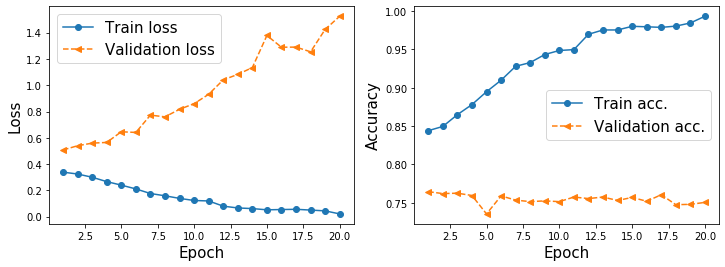

In [63]:
import matplotlib.pyplot as plt

my_hist = history.history
x_arr = np.arange(len(my_hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, my_hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, my_hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, my_hist['acc'], '-o', label='Train acc.')
ax.plot(x_arr, my_hist['val_acc'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

My graphs do not look as good as I would like them to. My training set accuracy and loss looks great but the validation curves do not look how I would like them to. My guess is that it is due to overfitting. I may add some dropout layers to reduce over-fitting if I have time.

As you can see my model did train when using a different method. There are some changes I could add to avoid overfitting but the main problem I am having is the input function.

Text(0, 0.5, 'Accuracy')

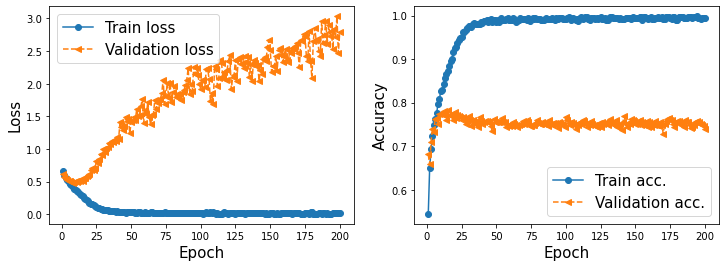

In [30]:
import matplotlib.pyplot as plt

my_hist2 = hist.history
x_arr = np.arange(len(my_hist2['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, my_hist2['loss'], '-o', label='Train loss')
ax.plot(x_arr, my_hist2['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, my_hist2['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, my_hist2['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

Above are the results of the model after adding the dropout layer. Unfortunately it still shows signs of overfitting.